# LSTM Model to detect Heel Strike and Toe-off events

In this notebook, we will predict whether each sample is a heel strike or toe-off based on the accelerometer data. To do so, we train an LSTM (Long-Short Term Memory) model on 70% of the data and test it on the remaining 30%

The LSTM architecture has
- a lookback window of 3 timesteps
- 6 features (X,Y,Z acceleration of left foot and right foot) 
- 44 hidden nodes

**The code is the same as that in Composite-Model.pynb, except that we use a for loop to iterate over all possible combinations of SUBJECT_ID, ACTIVITY and EVENT**

The subsequent steps to tune and test the model are as follows:

1. Subset the data based on subject, activity, and event
2. Oversampling and adding in composite accelerations
3. Remove noise from the data
4. Re-scale each of the features to range (0,5)
5. Split the data into training and testing sets  
6. Since we are using an LSTM architecture, we will implement a look-back function that will introduce historical data determined by the window size
7. Build and compile the Neural Network
8. Fit the model
9. Save the predictions and actual value to evaluate the model. The model is evaluated in terms of 
    - F1 score
    - Percentage of true positives
    - Mean of the absolute difference in time between true positives and corresponding GT events

In [22]:
import numpy
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

# Note: before you run the code

You can adjust the list of subject Ids, activities and events in the next cell.
Some parts are specific to indoors/outdoors, so you will need to comment the part if needed, and uncomment it it's if not needed.

## 1. Specify the list of subjects, activities and events


In [23]:
####### Select Subject Id #######
# Key in a number from 1 to 20. 

SUBJECT_ID_LIST = ['8']
# indoors
# SUBJECT_ID_LIST = ['1','2','3','4','5','6','7','8','9','10','11']
# # outdoors
# SUBJECT_ID_LIST = ['12','13','14','15','16','17','18','19','20']

###### Select Activity ######
# Key in one of the options below:

# indoors
ACTIVITY_LIST = ['treadmill_run','treadmill_all','indoor_walk','indoor_run','indoor_walknrun']
# ACTIVITY_LIST = ['treadmill_walk','treadmill_walknrun','treadmill_run','treadmill_all','indoor_walk','indoor_run','indoor_walknrun']
# outdoors
# ACTIVITY_LIST = ['outdoor_walk','outdoor_run','outdoor_walknrun']

###### Select Event ######
# EVENT_LIST = ['RF_TO']
EVENT_LIST = ['LF_HS','LF_TO','RF_HS','RF_TO']

## 2. Define helper functions

We will define two functions to be used in the for loop later, one to create a indicator variable for 'treadmill_all', the other to create the dataset for feeding into the RNN.

Since there is no indicator variable for treadmill_all for subjects 1-11, let's create another column which for this. The value of this data is 1 if either treadmill_walknrun is 1 or treadmill_slope_walk is 1

In [24]:
###############################################
######## Specific to indoors only #############
###############################################

# for SUBJECT_ID 1 to 11, uncomment if otherwise
# we will use this function in the for loop later

def label_treadmill_all (row):
   if row['treadmill_walknrun'] == 1:
      return 1
   if row['treadmill_slope_walk'] == 1:
      return 1
   return 0

def label_treadmill_run (row):
   if row['treadmill_walknrun'] == 1 and row['treadmill_walk'] == 0:
      return 1
   return 0

def label_indoor_run (row):
   if row['indoor_walknrun'] == 1 and row['indoor_walk'] == 0:
      return 1
   return 0

###############################################
######## Specific to outdoors only ############
###############################################

# for SUBJECT_ID 12 to 20, uncomment if otherwise
# we will use this function in the for loop later

def label_outdoor_run (row):
   if row['outdoor_walknrun'] == 1 and row['outdoor_walk'] == 0:
      return 1
   return 0

We define another function called oversampling. This will change the indicators for HS and TOs to '1' of time steps close to the actual HS and TOs

In [25]:
def oversample(event):
    global df
    temp_list = []
    for i in range(len(df)):
        if i>=2 and i+3<=len(df):
            if df[event][i-1]==1 or df[event][i]==1 or df[event][i+1]==1:
            # if df[event][i-2]==1 or df[event][i-1]==1 or df[event][i]==1 or df[event][i+1]==1 or df[event][i+2]==1:
                temp_list.append(1)
            else:
                temp_list.append(0)
        else:
            temp_list.append(0)
#     return temp_list
    df[event+'_2']=temp_list

In [26]:
# convert an array of values into a dataset matrix
# we will use this function in the for loop later
def create_dataset(dataset, look_back=1):
	dataX, dataY, dataZ = [], [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:14]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 15])
		dataZ.append(dataset[i + look_back, 14])        
	return numpy.array(dataX), numpy.array(dataY), numpy.array(dataZ)

## 3. Train Model and save Predictions

If training for indoor activity, use the next cell and comment the cell after that.

If training for indoor activity, comment the next cell and use the cell after that.

Currently running for:  -Subject: 8 -Activity: treadmill_run -Event: LF_HS


/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tankh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


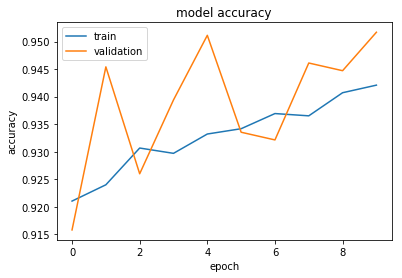

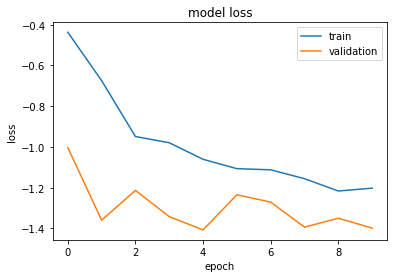

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_115 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_172 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_116 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_173 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_58 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


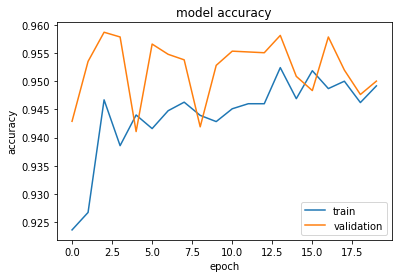

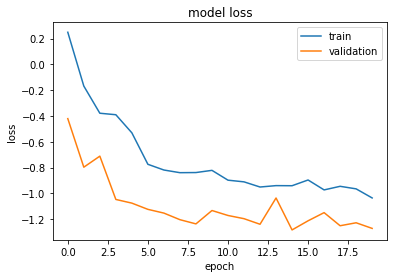

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_117 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_175 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_118 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_176 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_59 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


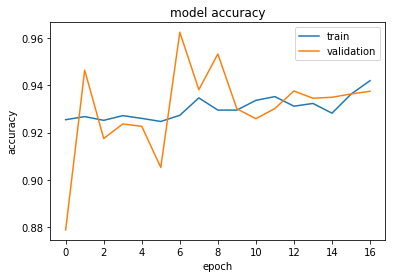

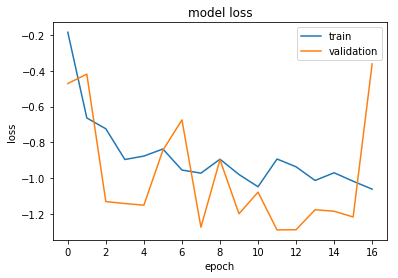

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_178 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_120 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_179 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_60 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


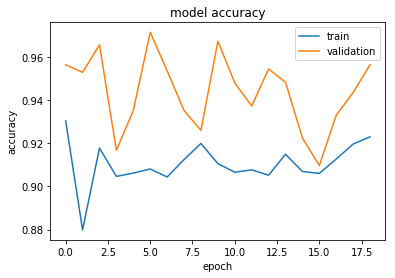

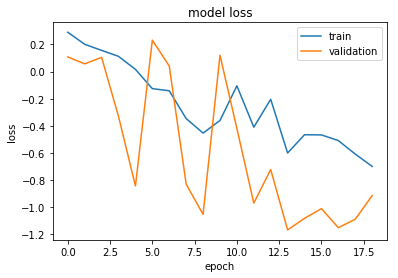

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_121 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_181 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_122 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_182 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_61 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


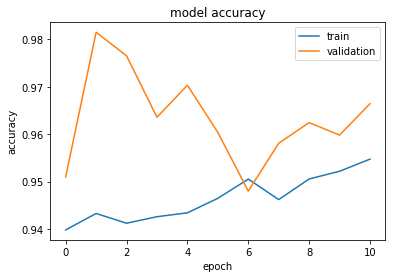

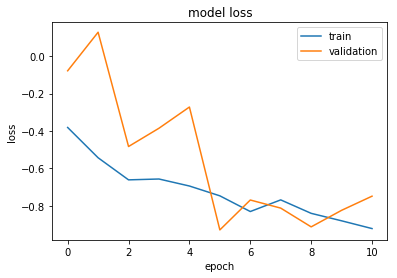

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_184 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_124 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_185 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_62 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


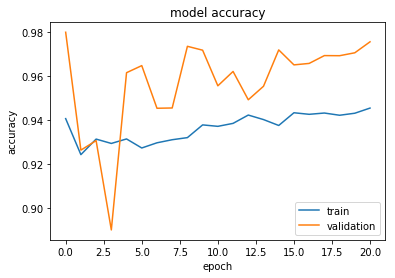

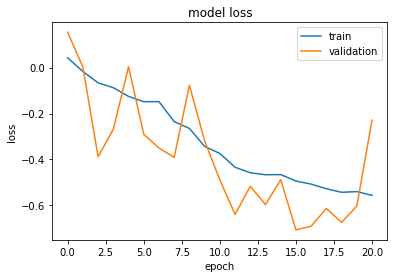

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_187 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_126 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_188 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_63 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_189 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


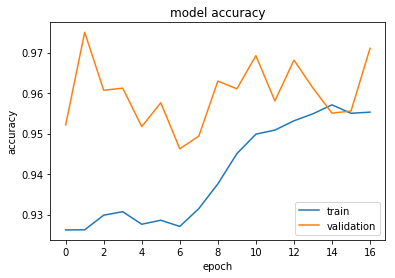

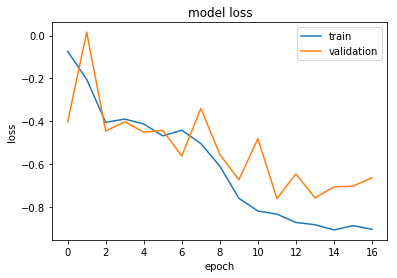

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_190 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_128 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_191 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_64 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


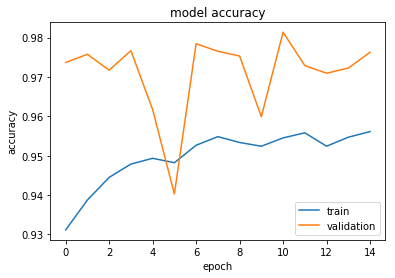

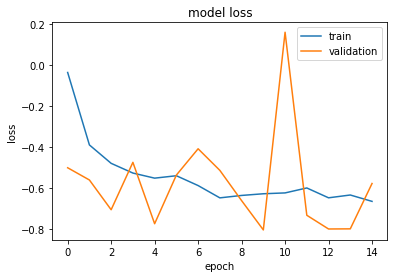

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_129 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_193 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_130 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_194 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_65 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


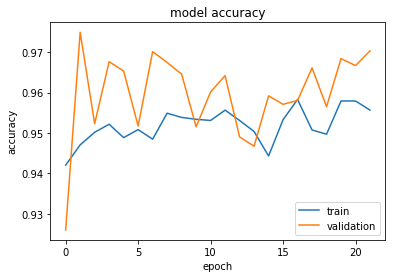

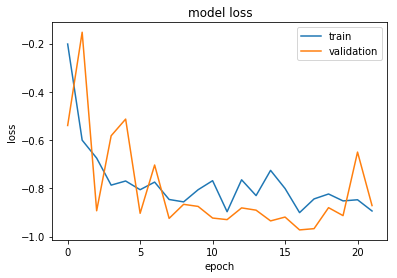

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_196 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_132 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_197 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_66 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


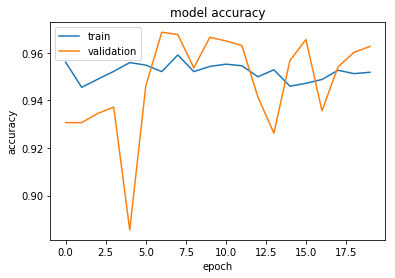

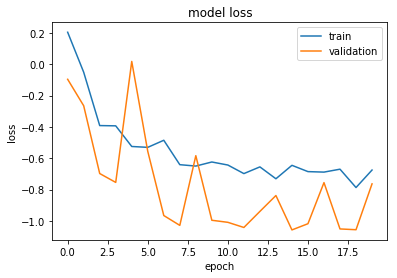

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_199 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_134 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_200 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_67 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


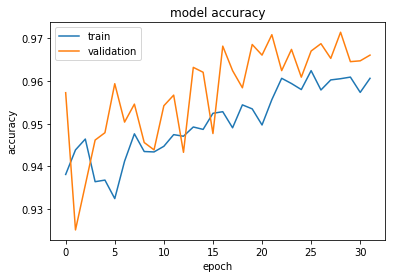

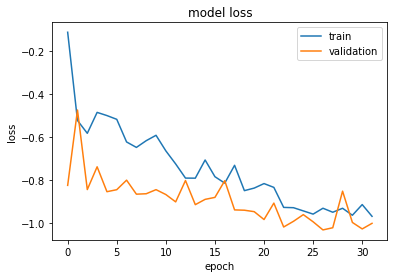

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_135 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_202 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_136 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_203 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_68 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_204 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


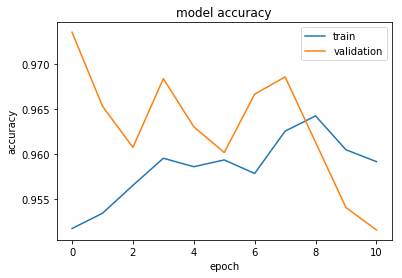

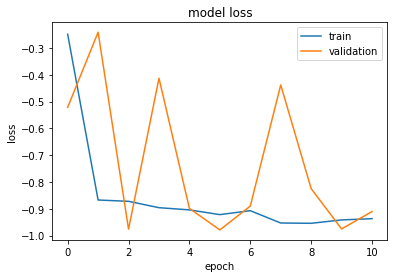

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_137 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_205 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_138 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_206 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_69 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


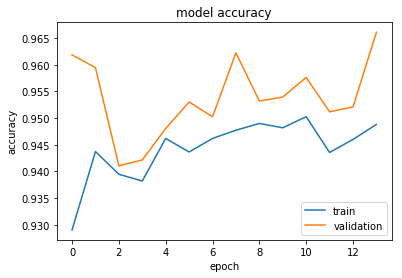

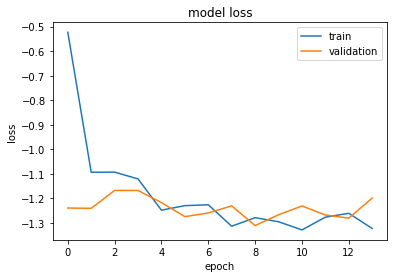

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_139 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_208 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_140 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_209 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_70 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_210 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


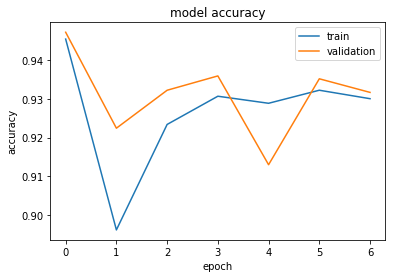

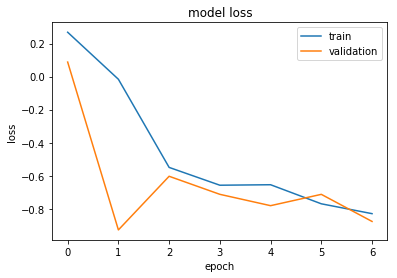

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_141 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_211 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_142 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_212 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_71 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


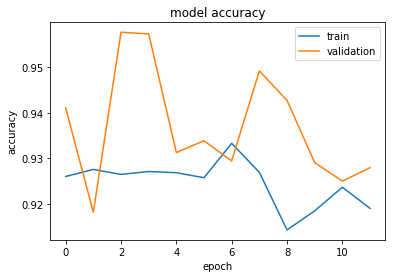

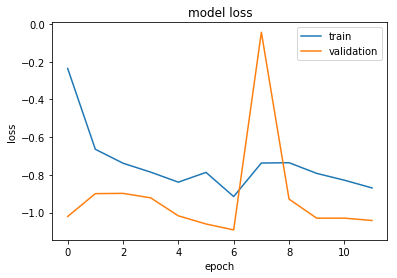

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_143 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_214 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_144 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_215 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_72 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_216 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


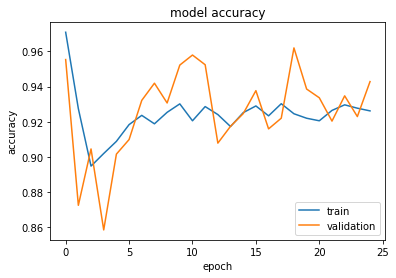

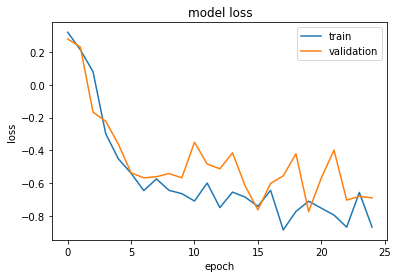

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_145 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_217 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_146 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_218 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_73 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_219 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


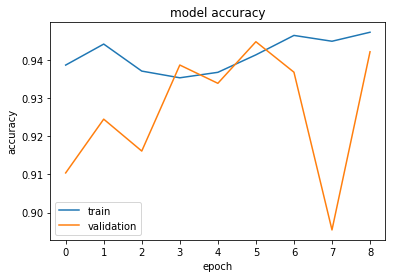

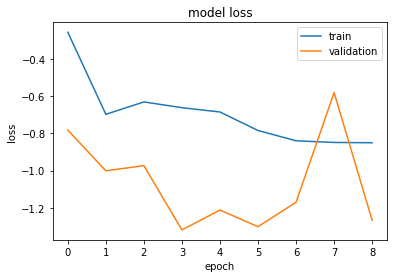

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_147 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_220 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_148 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_221 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_74 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


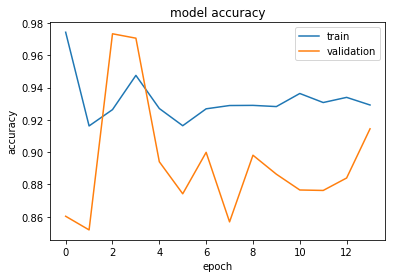

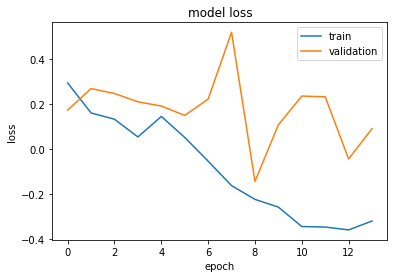

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_149 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_223 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_150 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_224 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_75 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_225 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


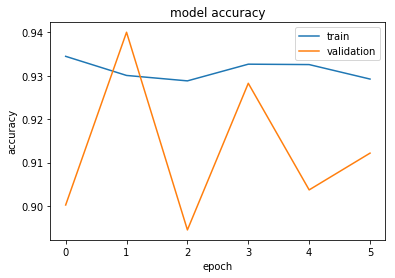

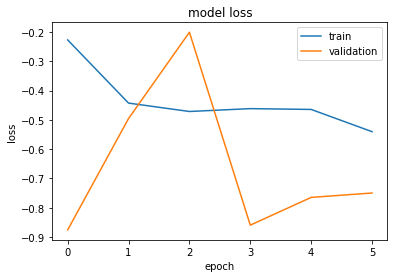

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_151 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_226 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_152 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_227 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_76 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_228 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________
Curren


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


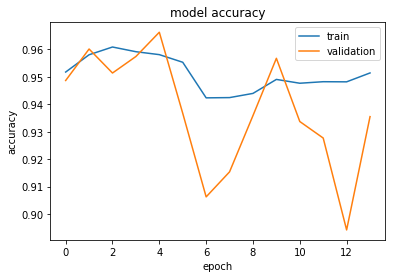

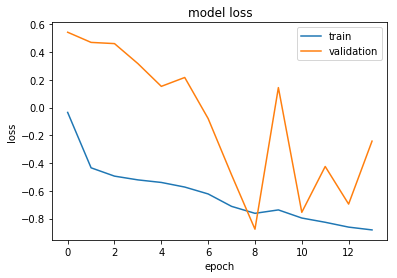

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_153 (LSTM)              (None, 3, 44)             10384     
_________________________________________________________________
dense_229 (Dense)            (None, 3, 44)             1980      
_________________________________________________________________
lstm_154 (LSTM)              (None, 44)                15664     
_________________________________________________________________
dense_230 (Dense)            (None, 44)                1980      
_________________________________________________________________
dropout_77 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 1)                 45        
Total params: 30,053
Trainable params: 30,053
Non-trainable params: 0
_________________________________________________________________


In [27]:
for SUBJECT_ID in SUBJECT_ID_LIST:
    for ACTIVITY in ACTIVITY_LIST:
        for EVENT in EVENT_LIST:
            # read in the data
            DATA_PATH = './Combined Data_csv format/'
            df = pd.read_csv(DATA_PATH + 'Sub_'+ SUBJECT_ID + '.csv', header = 0)          
            df = df.drop(df.columns[0], axis=1)
            df['treadmill_all']=df.apply (lambda row: label_treadmill_all(row),axis=1)
            df['treadmill_run']=df.apply (lambda row: label_treadmill_run(row),axis=1)
            df['indoor_run']=df.apply (lambda row: label_indoor_run(row),axis=1)
            
            oversample(EVENT)
            
            print("Currently running for: " + " -Subject: " + SUBJECT_ID + ' -Activity: ' + ACTIVITY + ' -Event: ' + EVENT)

            # Subset out the data by activity of interest
            k1=df[df[ACTIVITY]==1]
            
            # Add in the composite acceleration: sqrt(accX^2+accY^2+accZ^2)
            k1['acc_LF'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accY_LF']*k1['accY_LF']+k1['accZ_LF']*k1['accZ_LF'])
            k1['acc_RF'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accY_RF']*k1['accY_RF']+k1['accZ_RF']*k1['accZ_RF'])

            k1['acc_LF_xy'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accY_LF']*k1['accY_LF'])
            k1['acc_RF_xy'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accY_RF']*k1['accY_RF'])

            k1['acc_LF_yz'] = np.sqrt(k1['accY_LF']*k1['accY_LF']+k1['accZ_LF']*k1['accZ_LF'])
            k1['acc_RF_yz'] = np.sqrt(k1['accY_RF']*k1['accY_RF']+k1['accZ_RF']*k1['accZ_RF'])

            k1['acc_LF_xz'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accZ_LF']*k1['accZ_LF'])
            k1['acc_RF_xz'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accZ_RF']*k1['accZ_RF'])
            
            # Select the columns you want -- the first few accelerometer data and event of interest
            k2 = k1[['accX_LF','accY_LF','accZ_LF','accX_RF','accY_RF','accZ_RF','acc_LF','acc_RF','acc_LF_xy','acc_RF_xy','acc_LF_yz','acc_RF_yz','acc_LF_xz','acc_RF_xz', EVENT, EVENT+'_2']]

            # Remove noise from data
            k2['accX_LF_median']=k2['accX_LF'].rolling(window=3).mean()
            k2['accY_LF_median']=k2['accY_LF'].rolling(window=3).mean()
            k2['accZ_LF_median']=k2['accZ_LF'].rolling(window=3).mean()
            k2['acc_LF_median']=k2['acc_LF'].rolling(window=3).mean()
            k2['acc_LF_median_xy']=k2['acc_LF_xy'].rolling(window=3).mean()
            k2['acc_LF_median_yz']=k2['acc_LF_yz'].rolling(window=3).mean()
            k2['acc_LF_median_xz']=k2['acc_LF_xz'].rolling(window=3).mean()

            k2['accX_RF_median']=k2['accX_RF'].rolling(window=3).mean()
            k2['accY_RF_median']=k2['accY_RF'].rolling(window=3).mean()
            k2['accZ_RF_median']=k2['accZ_RF'].rolling(window=3).mean()
            k2['acc_RF_median']=k2['acc_RF'].rolling(window=3).mean()
            k2['acc_RF_median_xy']=k2['acc_RF_xy'].rolling(window=3).mean()
            k2['acc_RF_median_yz']=k2['acc_RF_yz'].rolling(window=3).mean()
            k2['acc_RF_median_xz']=k2['acc_RF_xz'].rolling(window=3).mean()

            k3 = k2[['accX_LF_median','accY_LF_median','accZ_LF_median','acc_LF_median','acc_LF_median_xy','acc_LF_median_yz','acc_LF_median_xz','accX_RF_median','accY_RF_median','accZ_RF_median','acc_RF_median','acc_RF_median_xy','acc_RF_median_yz', 'acc_RF_median_xz', EVENT, EVENT+'_2']]
            k3 = k3.iloc[2:]
            dataset = k3.values

            # normalize the dataset
            scaler = MinMaxScaler(feature_range=(0, 5))
            dataset = scaler.fit_transform(dataset)

######### Change this part for 3-fold cross-validation ############
            
#             # split into train and test sets (set 1: train on 1st 70% and test on last 30%)
#             train_size = int(len(dataset) * 0.7)
#             test_size = len(dataset) - train_size
#             train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
            
            # split into train and test sets (set 2: train on 1st 35% and last 35%, test on middle 30%)
            train_size = int(len(dataset) * 0.7)
            test_size = len(dataset) - train_size
            train, test = np.concatenate((dataset[0:int(train_size/2),:],dataset[int(train_size/2)+test_size:len(dataset),:]), axis=0), dataset[int(train_size/2):int(train_size/2)+test_size,:]

#             # split into train and test sets (set 3: train on last 70% and test on first 30%)
#             train_size = int(len(dataset) * 0.7)
#             test_size = len(dataset) - train_size
#             train, test = dataset[test_size:len(dataset),:], dataset[0:test_size,:]

            look_back=3 # 3 timesteps
            trainX, trainY, trainZ = create_dataset(train, look_back)
            testX, testY, testZ = create_dataset(test, look_back)
            
            model = Sequential()

            # Recurrent layer
            model.add(LSTM(44, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
            # Fully connected layer
            model.add(Dense(44, activation='relu'))
            # Recurrent layer
            model.add(LSTM(44, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
            # Fully connected layer
            model.add(Dense(44, activation='relu'))
            # Dropout for regularization
            model.add(Dropout(0.5))
            # Output layer
            model.add(Dense(1, activation='sigmoid'))
            # Compile the model
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # Fit the model
            es= EarlyStopping(monitor='val_loss', min_delta=0,patience=5,verbose=0, mode='auto')
            history = model.fit(trainX, trainY, validation_split = 0.33, epochs=50, batch_size=20, verbose=0, callbacks=[TQDMNotebookCallback(),es])

            # List all data in history
            print(history.history.keys())

            # summarize history for accuracy
            plt.plot(history.history['acc'])
            plt.plot(history.history['val_acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train','validation'])
            plt.show()

            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train','validation'])
            plt.show()

            model.summary()

            testY_predict = model.predict(testX)

            predicted = []
            actual = []
            for i in range(len(testZ)):
                #print(int(testY_predict[i]>0.5), int(testZ[i]>0.5))
                predicted.append(int(testY_predict[i]>0.5))
                actual.append(int(testZ[i]>0.5))

            PREDICTIONS_DF = pd.DataFrame(list(zip(predicted, actual)), columns=['predicted','actual'])

######### Change this part for 3-fold cross-validation ############
            
            # write dataframe to .csv
#             SAVE_PATH = './Predicted Data_model_csv format_1/'
            SAVE_PATH = './Predicted Data_model_csv format_2/'
#             SAVE_PATH = './Predicted Data_model_csv format_3/'
            PREDICTIONS_DF.to_csv(SAVE_PATH+'Sub'+SUBJECT_ID+'_'+ ACTIVITY + '_'+ EVENT + '.csv', encoding='utf-8')

In [28]:
# for SUBJECT_ID in SUBJECT_ID_LIST:
#     for ACTIVITY in ACTIVITY_LIST:
#         for EVENT in EVENT_LIST:
#             # read in the data
#             DATA_PATH = './Combined Data_csv format/'
#             df = pd.read_csv(DATA_PATH + 'Sub_'+ SUBJECT_ID + '.csv', header = 0)          
#             df = df.drop(df.columns[0], axis=1)
#             df['outdoor_run']=df.apply (lambda row: label_outdoor_run(row),axis=1)
            
#             oversample(EVENT)
            
#             print("Currently running for: " + " -Subject: " + SUBJECT_ID + ' -Activity: ' + ACTIVITY + ' -Event: ' + EVENT)

#             # Subset out the data by activity of interest
#             k1=df[df[ACTIVITY]==1]
            
#             # Add in the composite acceleration: sqrt(accX^2+accY^2+accZ^2)
#             k1['acc_LF'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accY_LF']*k1['accY_LF']+k1['accZ_LF']*k1['accZ_LF'])
#             k1['acc_RF'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accY_RF']*k1['accY_RF']+k1['accZ_RF']*k1['accZ_RF'])

#             k1['acc_LF_xy'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accY_LF']*k1['accY_LF'])
#             k1['acc_RF_xy'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accY_RF']*k1['accY_RF'])

#             k1['acc_LF_yz'] = np.sqrt(k1['accY_LF']*k1['accY_LF']+k1['accZ_LF']*k1['accZ_LF'])
#             k1['acc_RF_yz'] = np.sqrt(k1['accY_RF']*k1['accY_RF']+k1['accZ_RF']*k1['accZ_RF'])

#             k1['acc_LF_xz'] = np.sqrt(k1['accX_LF']*k1['accX_LF']+k1['accZ_LF']*k1['accZ_LF'])
#             k1['acc_RF_xz'] = np.sqrt(k1['accX_RF']*k1['accX_RF']+k1['accZ_RF']*k1['accZ_RF'])
            
#             # Select the columns you want -- the first few accelerometer data and event of interest
#             k2 = k1[['accX_LF','accY_LF','accZ_LF','accX_RF','accY_RF','accZ_RF','acc_LF','acc_RF','acc_LF_xy','acc_RF_xy','acc_LF_yz','acc_RF_yz','acc_LF_xz','acc_RF_xz', EVENT, EVENT+'_2']]

#             # Remove noise from data
#             k2['accX_LF_median']=k2['accX_LF'].rolling(window=3).mean()
#             k2['accY_LF_median']=k2['accY_LF'].rolling(window=3).mean()
#             k2['accZ_LF_median']=k2['accZ_LF'].rolling(window=3).mean()
#             k2['acc_LF_median']=k2['acc_LF'].rolling(window=3).mean()
#             k2['acc_LF_median_xy']=k2['acc_LF_xy'].rolling(window=3).mean()
#             k2['acc_LF_median_yz']=k2['acc_LF_yz'].rolling(window=3).mean()
#             k2['acc_LF_median_xz']=k2['acc_LF_xz'].rolling(window=3).mean()

#             k2['accX_RF_median']=k2['accX_RF'].rolling(window=3).mean()
#             k2['accY_RF_median']=k2['accY_RF'].rolling(window=3).mean()
#             k2['accZ_RF_median']=k2['accZ_RF'].rolling(window=3).mean()
#             k2['acc_RF_median']=k2['acc_RF'].rolling(window=3).mean()
#             k2['acc_RF_median_xy']=k2['acc_RF_xy'].rolling(window=3).mean()
#             k2['acc_RF_median_yz']=k2['acc_RF_yz'].rolling(window=3).mean()
#             k2['acc_RF_median_xz']=k2['acc_RF_xz'].rolling(window=3).mean()

#             k3 = k2[['accX_LF_median','accY_LF_median','accZ_LF_median','acc_LF_median','acc_LF_median_xy','acc_LF_median_yz','acc_LF_median_xz','accX_RF_median','accY_RF_median','accZ_RF_median','acc_RF_median','acc_RF_median_xy','acc_RF_median_yz', 'acc_RF_median_xz', EVENT, EVENT+'_2']]
#             k3 = k3.iloc[2:]
#             dataset = k3.values

#             # normalize the dataset
#             scaler = MinMaxScaler(feature_range=(0, 5))
#             dataset = scaler.fit_transform(dataset)

# ######### Change this part for 3-fold cross-validation ############
            
# #             # split into train and test sets (set 1: train on 1st 70% and test on last 30%)
# #             train_size = int(len(dataset) * 0.7)
# #             test_size = len(dataset) - train_size
# #             train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
            
#             # split into train and test sets (set 2: train on 1st 35% and last 35%, test on middle 30%)
#             train_size = int(len(dataset) * 0.7)
#             test_size = len(dataset) - train_size
#             train, test = np.concatenate((dataset[0:int(train_size/2),:],dataset[int(train_size/2)+test_size:len(dataset),:]), axis=0), dataset[int(train_size/2):int(train_size/2)+test_size,:]

# #             # split into train and test sets (set 3: train on last 70% and test on first 30%)
# #             train_size = int(len(dataset) * 0.7)
# #             test_size = len(dataset) - train_size
# #             train, test = dataset[test_size:len(dataset),:], dataset[0:test_size,:]

#             look_back=3 # 3 timesteps
#             trainX, trainY, trainZ = create_dataset(train, look_back)
#             testX, testY, testZ = create_dataset(test, look_back)
            
#             model = Sequential()

#             # Recurrent layer
#             model.add(LSTM(44, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
#             # Fully connected layer
#             model.add(Dense(44, activation='relu'))
#             # Recurrent layer
#             model.add(LSTM(44, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
#             # Fully connected layer
#             model.add(Dense(44, activation='relu'))
#             # Dropout for regularization
#             model.add(Dropout(0.5))
#             # Output layer
#             model.add(Dense(1, activation='sigmoid'))
#             # Compile the model
#             model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#             # Fit the model
#             es= EarlyStopping(monitor='val_loss', min_delta=0,patience=5,verbose=0, mode='auto')
#             history = model.fit(trainX, trainY, validation_split = 0.33, epochs=50, batch_size=20, verbose=0, callbacks=[TQDMNotebookCallback(),es])

#             # List all data in history
#             print(history.history.keys())

#             # summarize history for accuracy
#             plt.plot(history.history['acc'])
#             plt.plot(history.history['val_acc'])
#             plt.title('model accuracy')
#             plt.ylabel('accuracy')
#             plt.xlabel('epoch')
#             plt.legend(['train','validation'])
#             plt.show()

#             # summarize history for loss
#             plt.plot(history.history['loss'])
#             plt.plot(history.history['val_loss'])
#             plt.title('model loss')
#             plt.ylabel('loss')
#             plt.xlabel('epoch')
#             plt.legend(['train','validation'])
#             plt.show()

#             model.summary()

#             testY_predict = model.predict(testX)

#             predicted = []
#             actual = []
#             for i in range(len(testZ)):
#                 #print(int(testY_predict[i]>0.5), int(testZ[i]>0.5))
#                 predicted.append(int(testY_predict[i]>0.5))
#                 actual.append(int(testZ[i]>0.5))

#             PREDICTIONS_DF = pd.DataFrame(list(zip(predicted, actual)), columns=['predicted','actual'])

# ######### Change this part for 3-fold cross-validation ############

#             # write dataframe to .csv
# #             SAVE_PATH = './Predicted Data_model_csv format_1/'
#             SAVE_PATH = './Predicted Data_model_csv format_2/'
# #             SAVE_PATH = './Predicted Data_model_csv format_3/'
#             PREDICTIONS_DF.to_csv(SAVE_PATH+'Sub'+SUBJECT_ID+'_'+ ACTIVITY + '_'+ EVENT + '.csv', encoding='utf-8')